# Solving the $\mathbb{t}^\top$ integral

In this notebook we validate our expressions for the vector $\mathbb{t}^\top$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from IPython.display import Latex
from scipy.special import binom

np.seterr(invalid="ignore", divide="ignore");

## Limits of integration

In the paper, we presented the expressions for the point of intersection between the terminator and the limb of both the occultor and occulted planet, both parametrized in terms of the angle $\xi$:

In [4]:
def compute_xi(b, theta, bo, ro):
    """
    Return the limits of integration for the tT integral.
    
    Note that we're in the F' frame, so theta is actually theta'.
    """
    # Occultor/terminator intersection
    # Must solve a quartic!
    xo = bo * np.sin(theta)
    yo = bo * np.cos(theta)
    A = (1 - b ** 2) ** 2
    B = -4 * xo * (1 - b ** 2)
    C = -2 * (
        b ** 4
        + ro ** 2
        - 3 * xo ** 2
        - yo ** 2
        - b ** 2 * (1 + ro ** 2 - xo ** 2 + yo ** 2)
    )
    D = -4 * xo * (b ** 2 - ro ** 2 + xo ** 2 + yo ** 2)
    E = (
        b ** 4
        - 2 * b ** 2 * (ro ** 2 - xo ** 2 + yo ** 2)
        + (ro ** 2 - xo ** 2 - yo ** 2) ** 2
    )
    x = np.roots([A, B, C, D, E])
    
    # Exclude imaginary roots
    x = np.array([xi.real for xi in x if np.abs(xi.imag) < 1e-8])
    
    # Exclude roots not on the terminator
    y = b * np.sqrt(1 - x ** 2)
    xprime = x * np.cos(theta) - y * np.sin(theta)
    yprime = x * np.sin(theta) + y * np.cos(theta)
    good = np.abs(xprime ** 2 + (yprime - bo) ** 2 - ro ** 2) < 1e-8
    x = x[good]

    xi0 = np.arctan2(np.sqrt(1 - x ** 2), x)

    # Intersection with the planet limb
    if (1 - xo) ** 2 + yo ** 2 < ro ** 2:
        xi1 = [0]
    else:
        xi1 = [np.pi]
    
    return np.append(xi0, xi1)

Let's verify that these expressions give us the correct points of intersection for the example in Figure 16:

In [5]:
def plot(b, theta, bo, ro, xi):
    """Plot the occultor, the occulted body, and the day/night terminator in frame F'."""
    # Equation of a rotated ellipse
    x0 = np.linspace(-1, 1, 1000)
    y0 = b * np.sqrt(1 - x0 ** 2)
    x = x0 * np.cos(theta) - y0 * np.sin(theta)
    y = x0 * np.sin(theta) + y0 * np.cos(theta)

    # Plot the curves
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.add_artist(plt.Circle((0, 0), 1, ec="k", fc="none"))
    ax.add_artist(plt.Circle((0, bo), ro, ec="k", fc="none"))
    ax.plot(x, y)

    # Indicate the angles
    ax.plot(0, 0, "k.")
    ax.plot([0, np.cos(theta)], [0, np.sin(theta)], "k--", lw=1)
    ax.plot([0, -np.cos(theta)], [0, -np.sin(theta)], "k--", lw=1)
    for i, xi_i in enumerate(xi):
        
        ax.plot(
            [0, np.cos(np.sign(b) * xi_i + theta)],
            [0, np.sin(np.sign(b) * xi_i + theta)],
            color="k",
            lw=1,
        )
        ax.plot(
            [np.cos(np.sign(b) * xi_i + theta)],
            [np.sin(np.sign(b) * xi_i + theta)],
            "C1o"
        )

        # tangent line
        x0 = np.cos(xi_i) * np.cos(theta)
        y0 = np.cos(xi_i) * np.sin(theta)
        ax.plot(
            [x0, np.cos(np.sign(b) * xi_i + theta)],
            [y0, np.sin(np.sign(b) * xi_i + theta)],
            color="k",
            ls="--",
            lw=0.5,
        )

    # Appearance
    ax.set_aspect(1)
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.25)
    ax.axis("off")
    return ax

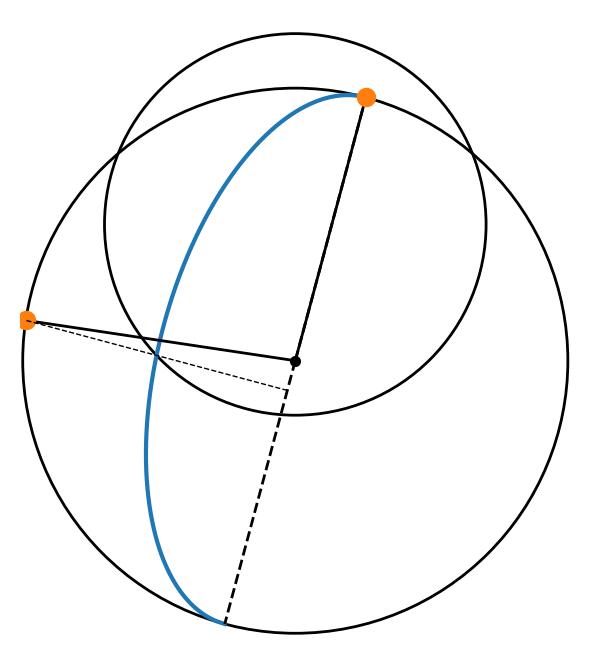

In [6]:
# input
b = 0.5
theta = 75 * np.pi / 180
bo = 0.5
ro = 0.7

# compute the angles
xi = compute_xi(b, theta, bo, ro)

# Plot
ax = plot(b, theta, bo, ro, xi);

The angle $\xi$ is measured counter-clockwise from the line connecting the origin to the endpoint of the terminator (this line is at an angle $\theta'$) with respect to the $x'$-axis. The starting angle is $\xi = 0$, since we begin the integration where the terminator comes into view. The second angle corresponds to the point of intersection between the terminator and the limb of the occultor. Note that this is **not** the usual polar angle; instead, $\xi$ is measured in the same way as the [ecccentric anomaly](https://en.wikipedia.org/wiki/Eccentric_anomaly) in a Keplerian orbit. It is the polar angle of the *projection* of the occultor-terminator intersection onto the unit disk.

Here are the two angles for future reference:

In [7]:
for i in range(2):
    display(Latex(r"${:.2f}^\circ$".format(xi[i] * 180 / np.pi)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Numerical evaluation

Now that we can compute `xi`, let's borrow some code from [Greens.ipynb](Greens.ipynb), where we showed how to evaluate $\mathbb{t}^\top$ numerically via Green's theorem. We'll compare our analytic solution to this numerical version.

In [8]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    """
    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        Gx, Gy = G(n)
        return Gx(x(theta), y(theta)) * dx(theta) + Gy(x(theta), y(theta)) * dy(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def tT_numerical(deg, xi, b, theta):
    """Compute the tT integral numerically from its integral definition."""
    N = (deg + 1) ** 2
    tT = np.zeros(N)
    for n in range(N):
        for xi1, xi2 in xi.reshape(-1, 2):
            x = lambda xi: np.cos(theta) * np.cos(xi) - b * np.sin(theta) * np.sin(xi)
            y = lambda xi: np.sin(theta) * np.cos(xi) + b * np.cos(theta) * np.sin(xi)
            dx = lambda xi: -np.cos(theta) * np.sin(xi) - b * np.sin(theta) * np.cos(xi)
            dy = lambda xi: -np.sin(theta) * np.sin(xi) + b * np.cos(theta) * np.cos(xi)
            tT[n] += primitive(x, y, dx, dy, xi1, xi2, n)
    return tT

## Analytic evaluation

Now let's code up the expression derived in the paper in terms of the matrix $\mathbb{H}$. We show how to evaluate this matrix analytically in the notebook [H.ipynb](H.ipynb), so here we'll evaluate it numerically for simplicity.

In [45]:
def computeH(umax, vmax, xi):
    """
    The matrix H evaluated by direct numerical integration.
    
    """
    H = np.zeros((umax + 1, vmax + 1))
    for u in range(umax + 1):
        for v in range(vmax + 1):
            for i in range(0, len(xi), 2):
                func = lambda x: np.cos(x) ** u * np.sin(x) ** v
                H[u, v] += quad(func, xi[i], xi[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return H


def Z(u, v, j, k, b, theta):
    """The function Z_{j,k}^{u,v}."""
    return (
        binom(u, j)
        * binom(v, k)
        * (-1) ** (v - k)
        * b ** (u + v - j - k)
        * np.sin(theta) ** (v + j - k)
        * np.cos(theta) ** (u - j + k)
    )


def tT(deg, xi, b, theta):
    """
    Compute the tT integral, evaluated in terms of the integral H.
    
    """
    # Initialize
    N = (deg + 1) ** 2
    tT = np.zeros(N) * np.nan

    # Pre-compute the helper integral
    H = computeH(deg + 2, deg + 2, xi)

    for n in range(N):

        # Get the mu, nu indices
        l = int(np.floor(np.sqrt(n)))
        m = n - l * l - l
        mu = l - m
        nu = l + m

        # Cases!
        if mu % 2 == 0:
            cterm = 0
            sterm = 0
            for j in range(nu // 2 + 1):
                for k in range((mu + 2) // 2 + 1):
                    cterm += (
                        Z(nu // 2, (mu + 2) // 2, j, k, b, theta)
                        * H[j + k + 1, l + 1 - j - k]
                    )
                    sterm += (
                        Z(nu // 2, (mu + 2) // 2, j, k, b, theta)
                        * H[j + k, l + 2 - j - k]
                    )
            tT[n] = b * np.cos(theta) * cterm - np.sin(theta) * sterm
        elif mu == nu == 1:
            res = 0
            sgn = -1
            for xi_i in xi:
                # Nudge xi away from zero, which is unstable
                if xi_i == 0: 
                    xi_i = 1e-15
                res += sgn * np.arctan(np.abs(b) * np.sin(xi_i) / np.cos(xi_i))
                bc = np.sqrt(1 - b ** 2)
                term = ((np.sin(xi_i) / (1 + np.cos(xi_i))) ** 2 + 2 * b ** 2 - 1) / (
                    2 * np.abs(b) * bc
                )
                res -= sgn * np.sign(np.sin(xi_i)) * (
                    np.arctan(term) + np.abs(b) * bc * np.cos(xi_i)
                )
                delta = 0
                if 0.5 * np.pi < xi_i and xi_i < np.pi:
                    delta = np.pi
                elif np.pi < xi_i and xi_i < 1.5 * np.pi:
                    delta = 2 * np.abs(b) * bc
                elif 1.5 * np.pi < xi_i and xi_i < 2 * np.pi:
                    delta = np.pi + 2 * np.abs(b) * bc
                res += sgn * delta
                sgn *= -1
            tT[n] = res / 3.0
        elif (nu % 2 == 1) and (mu == 1) and (l % 2 == 0):
            cterm = 0
            sterm = 0
            for j in range(l - 1):
                sterm += Z(0, l - 2, 0, j, b, theta) * H[j + 1, l + 1 - j]
                cterm += Z(0, l - 2, 0, j, b, theta) * H[j, l + 2 - j]

            tT[n] = -b * np.sin(theta) * sterm - np.cos(theta) * cterm
            tT[n] *= (1 - b ** 2) ** 1.5
        elif (nu % 2 == 1) and (mu == 1) and (l % 2 != 0):
            cterm = 0
            sterm = 0
            csterm = 0
            for j in range(l - 2):
                sterm += Z(0, l - 3, 0, j, b, theta) * H[j + 2, l - j]
                cterm += Z(0, l - 3, 0, j, b, theta) * H[j, l + 2 - j]
                csterm += Z(0, l - 3, 0, j, b, theta) * H[j + 1, l + 1 - j]
            tT[n] = (
                -b * np.sin(theta) ** 2 * sterm
                - b * np.cos(theta) ** 2 * cterm
                - (1 + b ** 2) * np.sin(theta) * np.cos(theta) * csterm
            )
            tT[n] *= (1 - b ** 2) ** 1.5
        else:
            cterm = 0
            sterm = 0
            for j in range((nu - 1) // 2 + 1):
                for k in range((mu - 3) // 2 + 1):
                    cterm += (
                        Z((nu - 1) // 2, (mu - 3) // 2, j, k, b, theta)
                        * H[j + k + 1, l + 1 - j - k]
                    )
                    sterm += (
                        Z((nu - 1) // 2, (mu - 3) // 2, j, k, b, theta)
                        * H[j + k, l + 2 - j - k]
                    )
            tT[n] = b * np.cos(theta) * cterm - np.sin(theta) * sterm
            tT[n] *= (1 - b ** 2) ** 1.5

    return tT

Finally, let's show that the numerical and analytic expressions agree up to degree 5 for the example in Figure 16:

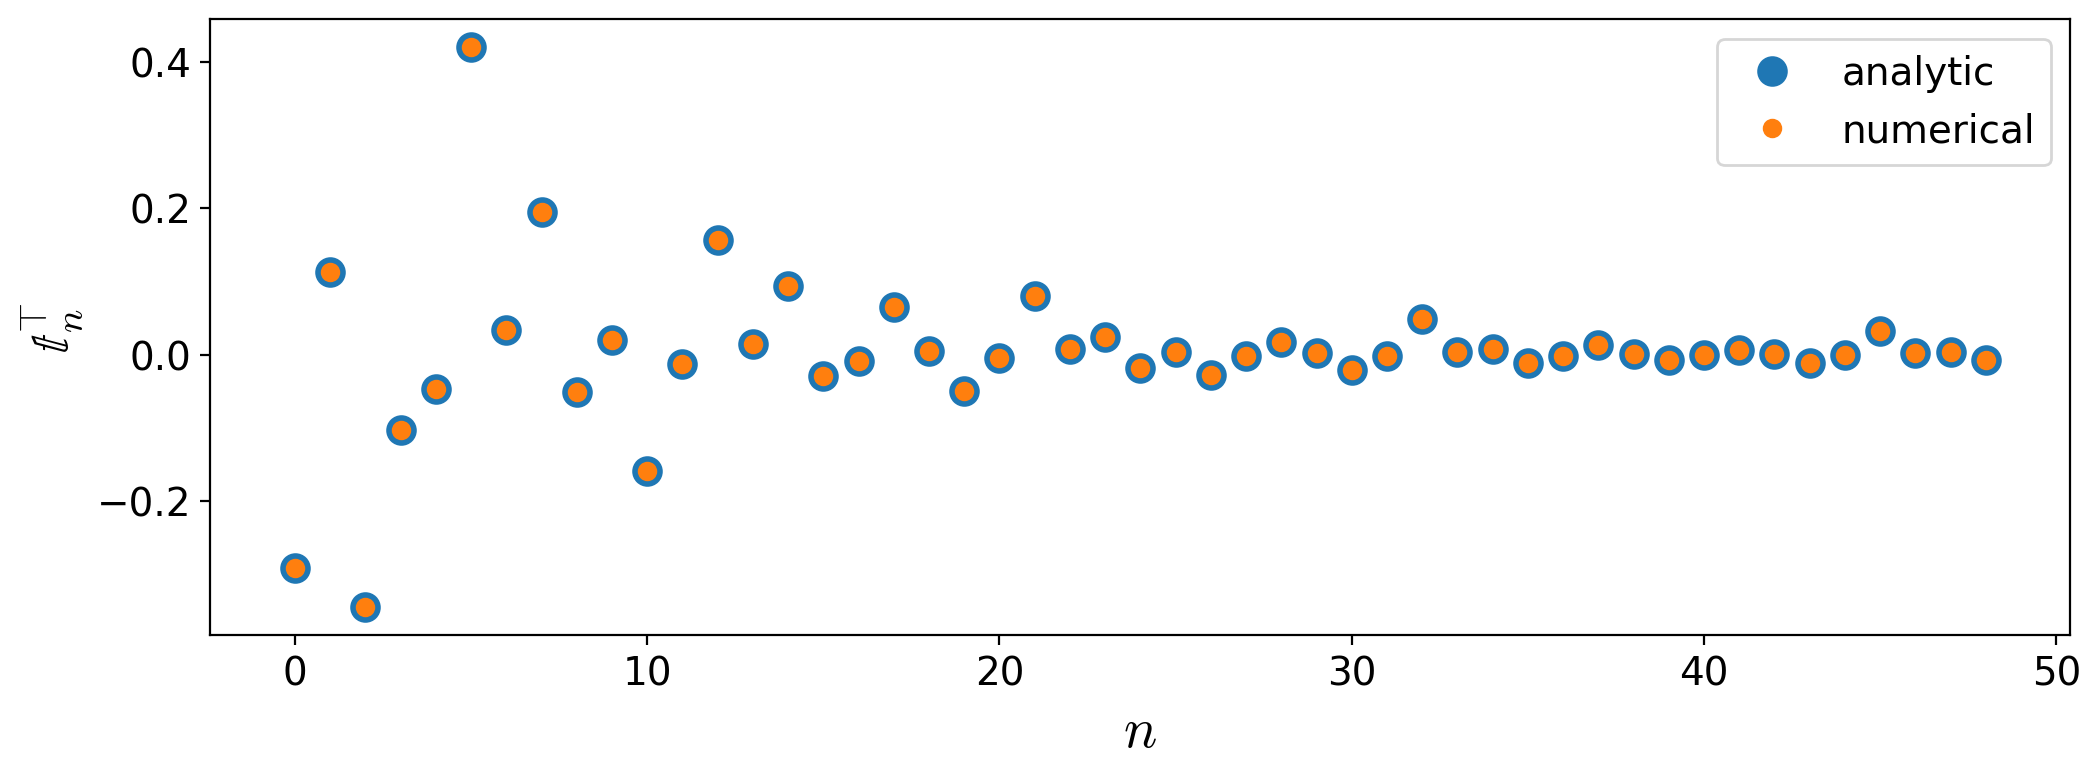

In [48]:
plt.plot(tT(6, xi, b, theta), "C0o", label="analytic", ms=10)
plt.plot(tT_numerical(6, xi, b, theta), "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$\mathbb{t}_n^\top$", fontsize=20);

The error is at the machine level:

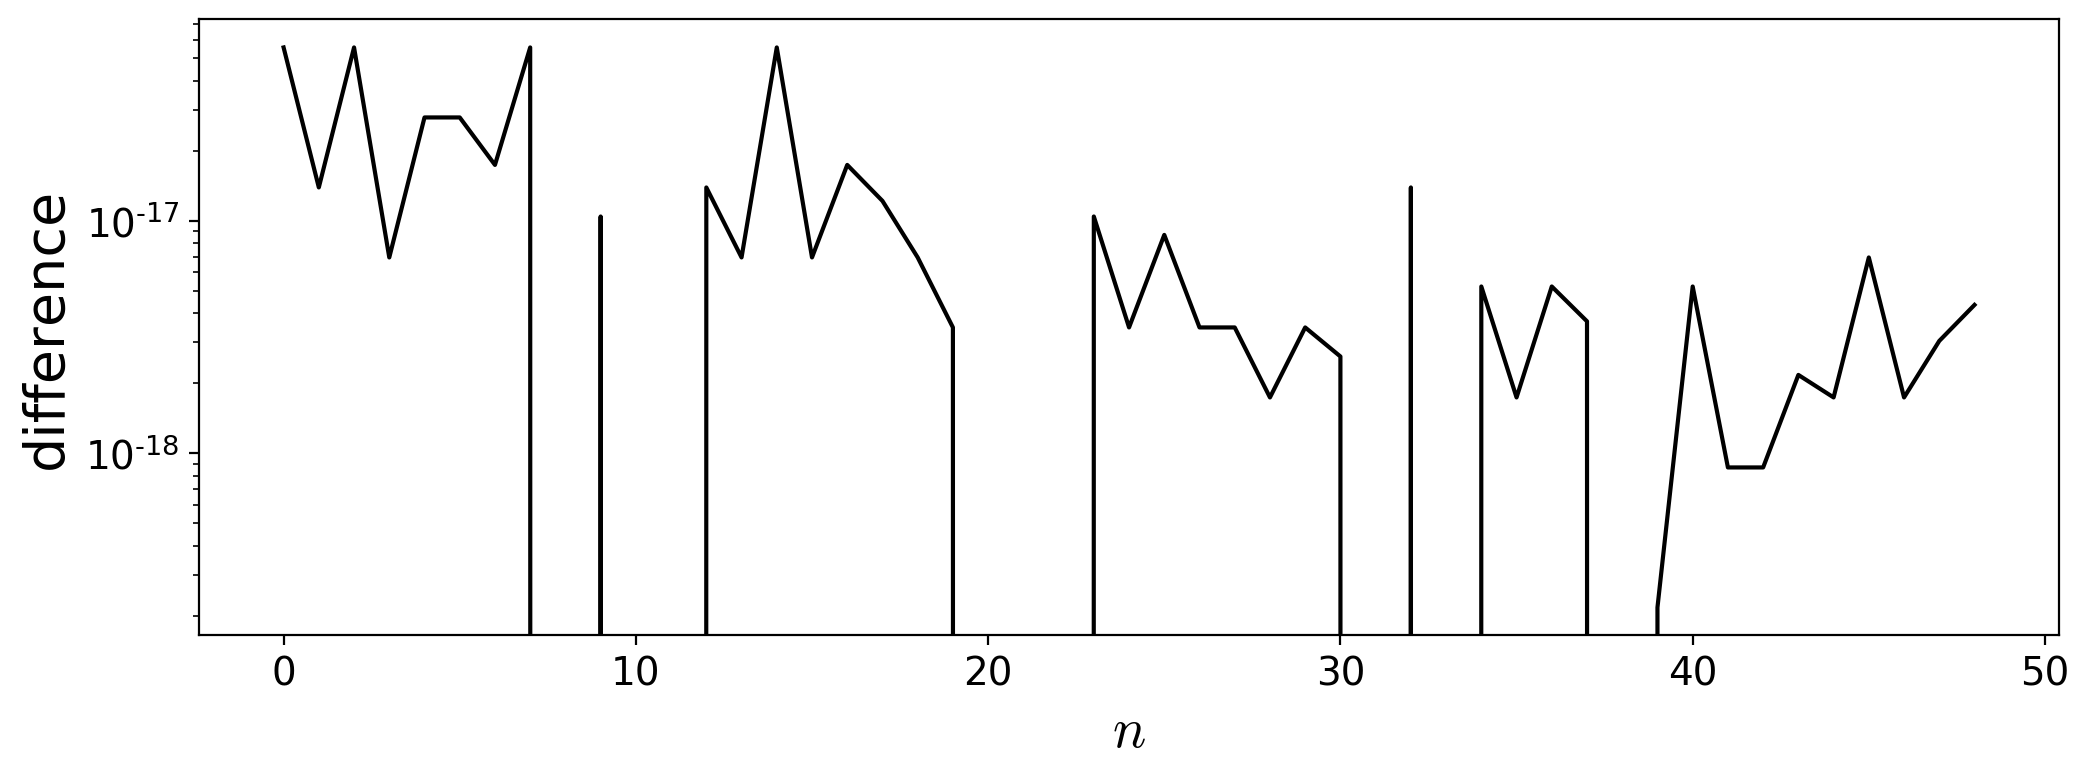

In [47]:
plt.plot(np.abs(tT(6, xi, bo, ro) - tT_numerical(6, xi, bo, ro)), "k-")
plt.xlabel(r"$n$", fontsize=20)
plt.yscale("log")
plt.ylabel(r"difference", fontsize=20);